# Analysis of Ergodicity in the Double Pendulum Simulations


In [62]:
import numpy as np
from pathlib import Path

folder = Path("./paths7")

arrays = []   # list of (theta1, theta2) arrays

for csv_file in sorted(folder.glob("*.csv")):
    data = np.loadtxt(csv_file, delimiter=",", skiprows=1)  # skip header if present
    arrays.append(data)

print(f"Loaded {len(arrays)} CSV files.")


Loaded 1000 CSV files.


## Comparison of the original thetas

In [63]:
theta1_means = [np.mean(traj[:, 0]) for traj in arrays] 
theta2_means = [np.mean(traj[:, 2]) for traj in arrays]

theta1_all = np.concatenate([traj[:, 0] for traj in arrays])
theta2_all = np.concatenate([traj[:, 2] for traj in arrays])

theta1_ens_mean = np.mean(theta1_all)
theta2_ens_mean = np.mean(theta2_all)

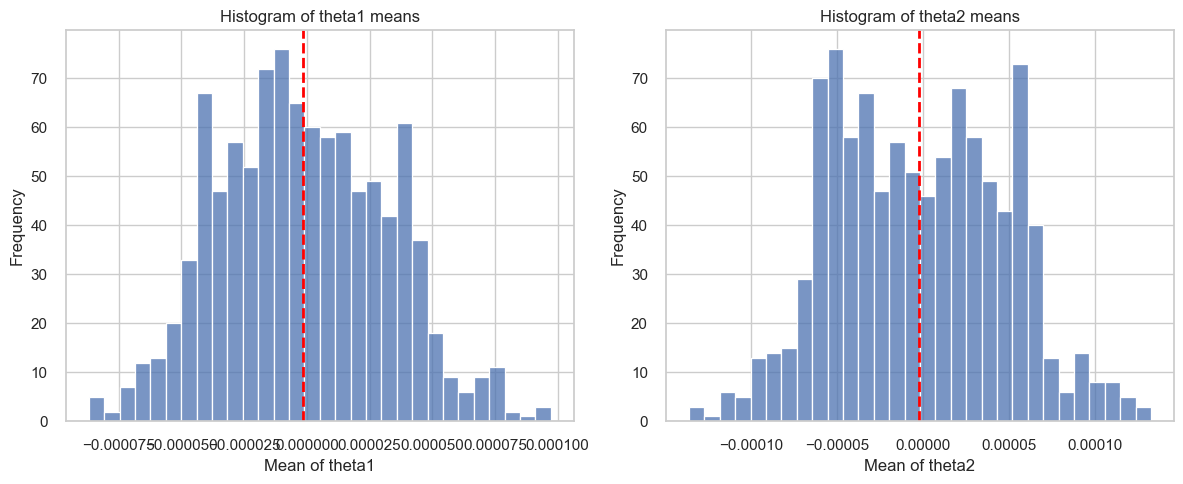

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: theta1 means ---
sns.histplot(theta1_means, bins=30, kde=False, ax=axes[0])
axes[0].axvline(theta1_ens_mean, color="red", linestyle="--", linewidth=2)
axes[0].set_xlabel("Mean of theta1")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of theta1 means")

# --- Right: theta2 means ---
sns.histplot(theta2_means, bins=30, kde=False, ax=axes[1])
axes[1].axvline(theta2_ens_mean, color="red", linestyle="--", linewidth=2)
axes[1].set_xlabel("Mean of theta2")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of theta2 means")

plt.tight_layout()
plt.show()


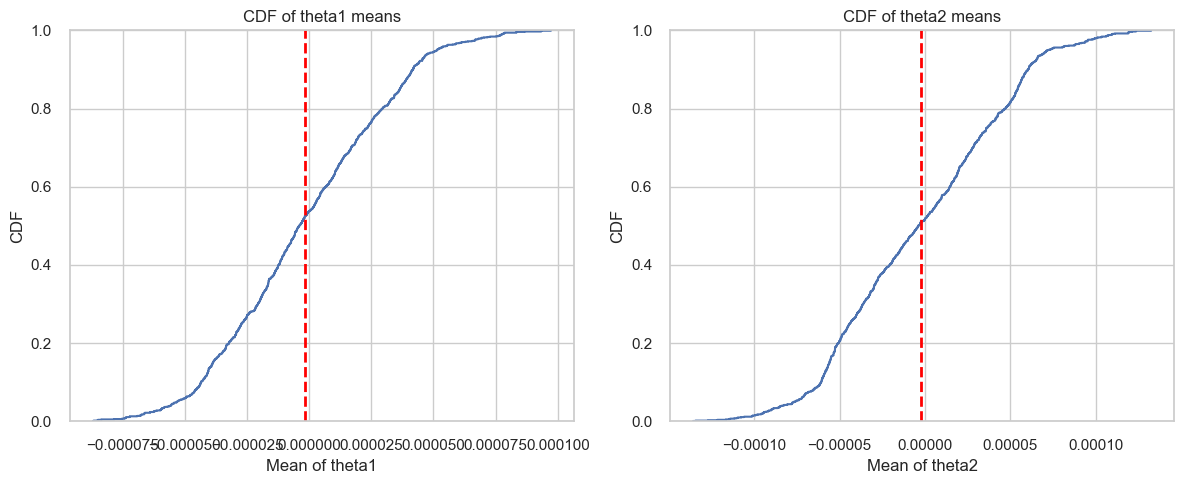

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: CDF of theta1 means ---
sns.ecdfplot(theta1_means, ax=axes[0])
axes[0].axvline(theta1_ens_mean, color="red", linestyle="--", linewidth=2)
axes[0].set_xlabel("Mean of theta1")
axes[0].set_ylabel("CDF")
axes[0].set_title("CDF of theta1 means")

# --- Right: CDF of theta2 means ---
sns.ecdfplot(theta2_means, ax=axes[1])
axes[1].axvline(theta2_ens_mean, color="red", linestyle="--", linewidth=2)
axes[1].set_xlabel("Mean of theta2")
axes[1].set_ylabel("CDF")
axes[1].set_title("CDF of theta2 means")

plt.tight_layout()
plt.show()


## Comparison of functions of theta1 and theta2

In [60]:
theta1_cos_means = [np.mean(np.cos(traj[:, 0])) for traj in arrays] 
theta2_cos_means = [np.mean(np.cos(traj[:, 2])) for traj in arrays]

theta1_cos_all = np.concatenate([np.cos(traj[:, 0]) for traj in arrays])
theta2_cos_all = np.concatenate([np.cos(traj[:, 2]) for traj in arrays])

theta1_cos_ens_mean = np.mean(theta1_cos_all)
theta2_cos_ens_mean = np.mean(theta2_cos_all)


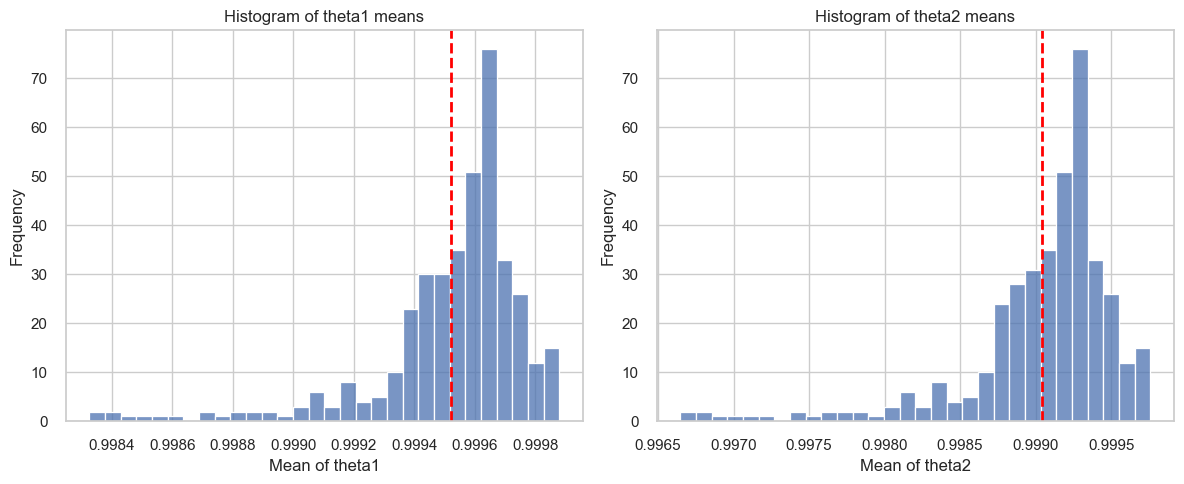

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: theta1 means ---
sns.histplot(theta1_cos_means, bins=30, kde=False, ax=axes[0])
axes[0].axvline(theta1_cos_ens_mean, color="red", linestyle="--", linewidth=2)
axes[0].set_xlabel("Mean of theta1")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of theta1 means")

# --- Right: theta2 means ---
sns.histplot(theta2_cos_means, bins=30, kde=False, ax=axes[1])
axes[1].axvline(theta2_cos_ens_mean, color="red", linestyle="--", linewidth=2)
axes[1].set_xlabel("Mean of theta2")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of theta2 means")

plt.tight_layout()
plt.show()
